In [144]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


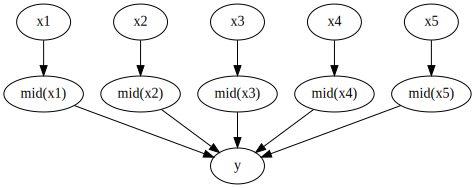

In [221]:
import dataclasses

import botorch
import networkx as nx
import torch
import math
import sysgym.params.boxes as boxes
import utils
from sysgym.params import ParamsSpace

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


@dataclasses.dataclass(init=False, frozen=True)
class MichalewiczSpace(ParamsSpace):
    x1: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x2: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x3: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x4: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x5: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)


problem = botorch.test_functions.Michalewicz(negate=True, dim=5, noise_std=0.0001)
space = MichalewiczSpace()
dag = nx.DiGraph()
dag.add_node("y")
for i in space:
    dag.add_node(i)
    # One term
    # dag.add_edges_from([(i, f"z({i})"), (f"z({i})", "y")])
    # Both terms:
    # dag.add_edges_from([(i, f"f1({i})"), (i, f"f2({i})"),
    #                     (f"f1({i})", "y"), (f"f2({i})", "y")
    #                     ])
    dag.add_edge(i, f'mid({i})')
    dag.add_edge(f'mid({i})', 'y')

utils.draw(dag)



In [222]:
from typing import Mapping
import bench_util


def eval_structure(x: torch.Tensor) -> torch.Tensor:
    m = 10
    return torch.sin(x) * torch.sin(problem.i * x**2 / math.pi) ** (2 * m)


In [226]:
from notebooks.bobn_ch import bobn
from autorocks.viz import plots_setup

bobn = bobn.BoBn(dag,
                 params=space,
                 objectives={'y'})

initial_train_x, initial_train_y = plots_setup.generate_data(10, problem)

initial_structure = eval_structure(initial_train_x)

initial_data = {
    'y': initial_train_y.tolist()
}
for idx, i in enumerate(space):
    initial_data[i] = initial_train_x[:, idx].tolist()
    initial_data[f"mid({i})"] = initial_structure[:, idx].tolist()
initial_data

group={'x3', 'mid(x3)'}
group={'mid(x1)', 'x1'}
group={'x4', 'mid(x4)'}
group={'mid(x5)', 'x5'}
group={'x2', 'mid(x2)'}
Built independent subgraph: {'x3', 'mid(x3)', 'y'}
Built independent subgraph: {'mid(x1)', 'y', 'x1'}
Built independent subgraph: {'x4', 'mid(x4)', 'y'}
Built independent subgraph: {'mid(x5)', 'x5', 'y'}
Built independent subgraph: {'x2', 'y', 'mid(x2)'}


{'y': [0.7102274513907804,
  0.0044335213487763534,
  0.4887612258903766,
  1.0161005713708813,
  1.1569832567422984,
  0.2921648856185117,
  0.34087111337585885,
  0.06790884456080848,
  1.366602463252803,
  0.9836700902425586],
 'x1': [2.8920576572418213,
  0.08408916741609573,
  1.1781970262527466,
  1.7358311414718628,
  2.1011998653411865,
  0.8624909520149231,
  0.39960426092147827,
  2.526496410369873,
  2.6564011573791504,
  0.6507018804550171],
 'mid(x1)': [4.6641238673184904e-08,
  9.350297466109328e-55,
  3.862328885583582e-08,
  0.01804288164609346,
  0.6552229833435623,
  1.93362759702529e-13,
  5.110650830651206e-27,
  0.06359399717638593,
  0.0032816027309371834,
  2.2297840849459994e-18],
 'x2': [3.0170583724975586,
  0.15568742156028748,
  1.947975516319275,
  1.2736778259277344,
  2.1859612464904785,
  0.924466609954834,
  2.666390895843506,
  0.395153284072876,
  1.633570671081543,
  1.526711106300354],
 'mid(x2)': [3.306373446440078e-08,
  9.076041280440061e-38,
  0

In [228]:
utils.clear_memory()

# BO loop
num_optimization_rounds = 100
num_restarts = 3
bobn_results = []

for restart_id in range(num_restarts):
    print(f"{restart_id=}/{num_restarts}")
    observations = {}
    observations.update(initial_data)
    best_f = float(initial_train_y.max())
    steps_to_best_f = 0
    for optimization_round in range(num_optimization_rounds):
        print(f"{restart_id=}:{optimization_round=}/{num_optimization_rounds}, {best_f=}, {steps_to_best_f=}")
        next_candidate = bobn.opt(observations)
        for k, v in next_candidate.items():
            observations[k].append(v)
        next_candidate_tensor = []
        for p in space:
            next_candidate_tensor.append(next_candidate[p])
        next_candidate_tensor = torch.tensor(next_candidate_tensor)
        y = float(problem(next_candidate_tensor))
        if y > best_f:
            best_f = y
            steps_to_best_f = optimization_round
        print(f"{y=}")
        observations['y'].append(float(y))
        structure_eval = eval_structure(next_candidate_tensor)
        for idx, i in enumerate(space):
            observations[f"mid({i})"].append(float(structure_eval[idx]))

        bobn_results.append(bench_util.ExperimentResult(
            model="BoBn",
            step=optimization_round,
            restart=restart_id,
            candidate=next_candidate,
            result=float(y),
            best_f=best_f,
            steps_to_best_f=steps_to_best_f
        ))



restart_id=0/3
restart_id=0:optimization_round=0/100, best_f=1.366602463252803, steps_to_best_f=0
y=3.42327880859375
restart_id=0:optimization_round=1/100, best_f=3.42327880859375, steps_to_best_f=0
y=3.663148880004883
restart_id=0:optimization_round=2/100, best_f=3.663148880004883, steps_to_best_f=1
y=3.4902241230010986
restart_id=0:optimization_round=3/100, best_f=3.663148880004883, steps_to_best_f=1
y=3.7405478954315186
restart_id=0:optimization_round=4/100, best_f=3.7405478954315186, steps_to_best_f=3
y=3.6866986751556396
restart_id=0:optimization_round=5/100, best_f=3.7405478954315186, steps_to_best_f=3
y=3.795424461364746
restart_id=0:optimization_round=6/100, best_f=3.795424461364746, steps_to_best_f=5
y=3.8172099590301514
restart_id=0:optimization_round=7/100, best_f=3.8172099590301514, steps_to_best_f=6
y=3.766071319580078
restart_id=0:optimization_round=8/100, best_f=3.8172099590301514, steps_to_best_f=6
y=3.910797595977783
restart_id=0:optimization_round=9/100, best_f=3.9107

In [229]:
utils.clear_memory()

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
botorch_results = []

for restart_id in range(num_restarts):
    print(f"{restart_id=}/{num_restarts}")
    train_x = initial_train_x.clone().to(**tkwargs)
    train_y = initial_train_y.clone().to(**tkwargs)
    best_f = float(initial_train_y.max())
    steps_to_best_f = 0
    for optimization_round in range(num_optimization_rounds):
        print(f"{restart_id=}:{optimization_round=}/{num_optimization_rounds}, {best_f=}, {steps_to_best_f=}")
        next_candidate = bench_util.botorch_optimize(train_x, train_y, problem, tkwargs)
        y = problem(next_candidate)
        if float(y) > best_f:
            best_f = float(y)
            steps_to_best_f = optimization_round
        print(f"{y=}")
        train_y = torch.concat([train_y, y])
        train_x = torch.concat([train_x, next_candidate])

        botorch_results.append(bench_util.ExperimentResult(
            model="BoTorch",
            step=optimization_round,
            restart=restart_id,
            candidate=next_candidate.squeeze().detach().cpu().tolist(),
            result=float(y),
            best_f=best_f,
            steps_to_best_f=steps_to_best_f
        ))




restart_id=0/3
restart_id=0:optimization_round=0/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.1590], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=1/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.7912], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=2/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([1.7632], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=3/100, best_f=1.7632176388672087, steps_to_best_f=2
y=tensor([1.1139], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=4/100, best_f=1.7632176388672087, steps_to_best_f=2
y=tensor([0.1612], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=5/100, best_f=1.7632176388672087, steps_to_best_f=2
y=tensor([0.1141], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=6/100, best_f=1.7632176388672087, steps_to_best_f=2
y=tensor([0.8682], device='cuda:0', dtype=torch.float64)
r

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0117], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=17/100, best_f=1.7632176388672087, steps_to_best_f=2
y=tensor([2.6374], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=18/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.5861], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=19/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.0645], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=20/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2372], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=21/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([9.0987e-05], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=22/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6182], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=23/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([0.0556], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=24/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1962], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=25/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6064], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=26/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2220], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=27/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.4910], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=28/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5172], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=29/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0319], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=30/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4523], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=31/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0886], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=32/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2791], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=33/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([8.2352e-06], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=34/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0833], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=35/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.6797], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=36/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2889], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=37/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4784], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=38/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.9620], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=39/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0304], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=40/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([0.7163], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=41/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6436], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=42/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([0.0016], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=43/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0035], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=44/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.9921], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=45/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([2.0476], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=46/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.6885], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=47/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.4888], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=48/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([2.1021], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=49/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.6062], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=50/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.6177], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=51/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([2.3888], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=52/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([2.0425], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=53/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.4768], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=54/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.3894], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=55/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([2.0310], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=56/100, best_f=2.6374110851846613, steps_to_best_f=17

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0960], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=60/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0303], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=61/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.4689], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=62/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.7032], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=63/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.3068], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=64/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([1.8399], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=65/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([0.7505], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=66/100, best_f=2.6374110851846613, steps_to_best_f=17


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6756], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=67/100, best_f=2.6374110851846613, steps_to_best_f=17
y=tensor([3.0728], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=68/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([2.4963], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=69/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([2.3712], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=70/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0050], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=71/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3351], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=72/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([2.5219], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=73/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0281], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=74/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.2195], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=75/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6308], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=76/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5882], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=77/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1026], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=78/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1527], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=79/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([1.5238], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=80/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([2.0507], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=81/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1208], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=82/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.8902], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=83/100, best_f=3.0728070056244396, steps_to_best_f=67
y=tensor([1.9665], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=84/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0858], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=85/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6579], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=86/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0297], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=87/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9716], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=88/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1021], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=89/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1314], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=90/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9055], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=91/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5604], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=92/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.8110], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=93/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3098], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=94/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.8164], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=95/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6125], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=96/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2650], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=97/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2436], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=98/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0998], device='cuda:0', dtype=torch.float64)
restart_id=0:optimization_round=99/100, best_f=3.0728070056244396, steps_to_best_f=67


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1696], device='cuda:0', dtype=torch.float64)
restart_id=1/3
restart_id=1:optimization_round=0/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.1587], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=1/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.7981], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=2/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([1.7490], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=3/100, best_f=1.748960422695879, steps_to_best_f=2
y=tensor([1.1522], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=4/100, best_f=1.748960422695879, steps_to_best_f=2
y=tensor([0.1968], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=5/100, best_f=1.748960422695879, steps_to_best_f=2
y=tensor([0.0202], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=6/100, best_f=1.748960422695879, steps_to_best_f=2
y=ten

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0491], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=23/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.9611], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=24/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.1164], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=25/100, best_f=1.832602223915322, steps_to_best_f=9


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6700], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=26/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.9594], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=27/100, best_f=1.832602223915322, steps_to_best_f=9


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2332], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=28/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([1.6363], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=29/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([1.4251], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=30/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.9491], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=31/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.4723], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=32/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([0.0766], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=33/100, best_f=1.832602223915322, steps_to_best_f=9


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0242], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=34/100, best_f=1.832602223915322, steps_to_best_f=9
y=tensor([1.8703], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=35/100, best_f=1.870255616845313, steps_to_best_f=34
y=tensor([2.5074], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=36/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.4221], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=37/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7697], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=38/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.6602], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=39/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.8960], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=40/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5240], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=41/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5827], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=42/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9642], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=43/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.8747], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=44/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0153], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=45/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5257], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=46/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2804], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=47/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3328], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=48/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.8524], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=49/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1297], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=50/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.1219], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=51/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.9170], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=52/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0100], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=53/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5770], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=54/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7262], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=55/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0511], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=56/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9316], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=57/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0232], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=58/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6811], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=59/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0003], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=60/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.2737], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=61/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0101], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=62/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0018], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=63/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1573], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=64/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.0398], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=65/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0215], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=66/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.4380], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=67/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([6.9191e-05], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=68/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0824], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=69/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.2552], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=70/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1110], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=71/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4081], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=72/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0708], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=73/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2922], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=74/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5843], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=75/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.7622], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=76/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7297], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=77/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6945], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=78/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.2645], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=79/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.2071], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=80/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.6928], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=81/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([1.8963], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=82/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.2762], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=83/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1861], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=84/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0037], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=85/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0736], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=86/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0287], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=87/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0073], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=88/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0037], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=89/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0002], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=90/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([-7.5468e-05], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=91/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7929], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=92/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4337], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=93/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5081], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=94/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.8219], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=95/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9403], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=96/100, best_f=2.5074095623224775, steps_to_best_f=35
y=tensor([0.1154], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=97/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0114], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=98/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.8885], device='cuda:0', dtype=torch.float64)
restart_id=1:optimization_round=99/100, best_f=2.5074095623224775, steps_to_best_f=35


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5476], device='cuda:0', dtype=torch.float64)
restart_id=2/3
restart_id=2:optimization_round=0/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.1555], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=1/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([0.8334], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=2/100, best_f=1.366602463252803, steps_to_best_f=0
y=tensor([1.7227], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=3/100, best_f=1.7226539513026213, steps_to_best_f=2
y=tensor([1.2162], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=4/100, best_f=1.7226539513026213, steps_to_best_f=2
y=tensor([0.2619], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=5/100, best_f=1.7226539513026213, steps_to_best_f=2
y=tensor([0.0007], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=6/100, best_f=1.7226539513026213, steps_to_best_f=2
y

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9107], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=20/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.8405], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=21/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.0146], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=22/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9094], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=23/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7813], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=24/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9681], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=25/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([-0.0001], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=26/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([1.6720], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=27/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.0125], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=28/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0034], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=29/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.1726], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=30/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0936], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=31/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4162], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=32/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.0720], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=33/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7013], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=34/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5396], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=35/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0001], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=36/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.0907], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=37/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9892], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=38/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([8.9274e-05], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=39/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.2292], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=40/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.6499], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=41/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0716], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=42/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([1.3031], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=43/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0022], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=44/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([1.2025], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=45/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6330], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=46/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([1.6116], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=47/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5540], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=48/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0006], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=49/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.9320], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=50/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.8562], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=51/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7036], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=52/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([1.6202], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=53/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0437], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=54/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.4326], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=55/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3622], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=56/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.4638], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=57/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5990], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=58/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.7240], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=59/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1720], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=60/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.7637], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=61/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6022], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=62/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.9536], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=63/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4255], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=64/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0778], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=65/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4207], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=66/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6320], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=67/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2318], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=68/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5251], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=69/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0729], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=70/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3790], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=71/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1214], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=72/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0168], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=73/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5077], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=74/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([9.3674e-06], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=75/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2215], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=76/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0984], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=77/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3375], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=78/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.5563], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=79/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.0488], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=80/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2272], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=81/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.8908], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=82/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.3679], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=83/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0115], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=84/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.6204], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=85/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0481], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=86/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.1012], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=87/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([1.1519], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=88/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0675], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=89/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4589], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=90/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7866], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=91/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2078], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=92/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([2.5397], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=93/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.5105], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=94/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.1818], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=95/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.0001], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=96/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.4614], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=97/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.7891], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=98/100, best_f=3.240202621923853, steps_to_best_f=14


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


y=tensor([0.2606], device='cuda:0', dtype=torch.float64)
restart_id=2:optimization_round=99/100, best_f=3.240202621923853, steps_to_best_f=14
y=tensor([0.6937], device='cuda:0', dtype=torch.float64)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


In [230]:
import pandas as pd

all_results = bobn_results + botorch_results
all_results_df = pd.DataFrame(all_results)
all_results_df

,model,step,restart,candidate,result,best_f,steps_to_best_f
0,BoBn,0,0,"{'x3': 1.3227853266308454, 'x1': 2.19296598452...",3.423279,3.423279,0
1,BoBn,1,0,"{'x3': 1.2851952342890804, 'x1': 2.20296039208...",3.663149,3.663149,1
2,BoBn,2,0,"{'x3': 1.2849370573787544, 'x1': 2.20331786745...",3.490224,3.663149,1
3,BoBn,3,0,"{'x3': 1.2849095646846571, 'x1': 2.20339289885...",3.740548,3.740548,3
4,BoBn,4,0,"{'x3': 1.284897139981373, 'x1': 2.203434567821...",3.686699,3.740548,3
...,...,...,...,...,...,...,...
595,BoTorch,95,2,"[3.065116519468636, 2.3058197310154593, 1.7364...",0.000143,3.240203,14
596,BoTorch,96,2,"[2.916617532683301, 2.2061130426686293, 0.4984...",0.461376,3.240203,14
597,BoTorch,97,2,"[1.1252150348847945, 0.8383931870509154, 2.230...",0.789082,3.240203,14
598,BoTorch,98,2,"[2.931047013856345, 2.8742964291418227, 0.8392...",0.260618,3.240203,14


In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rc("text", usetex=False)
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")
plt.rc("axes", labelsize="medium")
plt.rc("pdf", use14corefonts=True)

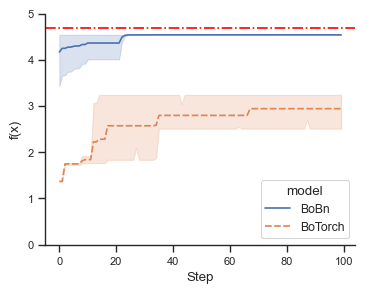

In [242]:
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.lineplot(data=all_results_df, x="step", y="best_f", hue="model", style='model', ax=ax)
ax.axhline(problem.optimal_value, ls='dashdot', label="Optimal value", color='red')
ax.set(xlabel="Step", ylabel="f(x)", ylim=(0, 5))

output_location = "/home/salabed/workspace/latex/thesis/phd_dissertation/Chapters/BoBn/Figures"
output_format = "svg"
fig.savefig(f"{output_location}/decomposition_convergence.{output_format}", bbox_inches = "tight", format = f"{output_format}",
          dpi = 300)
output_format = "pdf"
fig.savefig(f"{output_location}/decomposition_convergence.{output_format}", bbox_inches = "tight", format = f"{output_format}",
          dpi = 300)

In [243]:
all_results_df.to_csv("bobn_exp_all_results_df.csv")